In [3]:
# setup
from mlwpy import*
%matplotlib inline

# Predicting Numerical Values: Getting Started with Regression

Regression predicts a finely graded numerical value from inputs.  To illustrate, we need a simple dataset with numerical results.  `sklearn` comes with the *diabetes* dataset that serves us nicely.  The dataset included with `sklearn` has been modified from faw numerical features by subtracting the mean and dividing by the standard deviation of each column.  The process is called *standardizing* or *z-scoring* the features.  We return to the standard deviation later.  Briefly, the standard deviation is a measure of how spread out a set of values are.

The net result of standardizing the columns is that each column has a mean of 0 and a standard deviation of 1.  When we standardize or rescale the data so that differences in feature ranges, such as heights within 50-100 inches or incomes from $20,000 to $200,000, don't incur undo weight penalties or benefits just from their scale.

We'll discuss standardization and scaling more in section 10.3.  The categorical values in *diabetes* were recorded numerically as {0, 1} and then standardized, which is why there are *negative* ages, (the mean age is zero after standardizing) and why the sexes are coded, or recorded, as {0.0507, -0.0446} instead of {*M, F*}.



In [4]:
diabetes = datasets.load_diabetes()

tts = skms.train_test_split(diabetes.data,
                            diabetes.target,
                            test_size=.25)

(diabetes_train_ftrs, diabetes_test_ftrs,
 diabetes_train_tgt, diabetes_test_tgt) = tts

We can dress the dataset up with a `DataFrame` and look at the first few rows:

In [5]:
diabetes_df = pd.DataFrame(diabetes.data,
                           columns=diabetes.feature_names)
diabetes_df['target'] = diabetes.target
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000


Aside from the odd values for seemingly categorical measures like age and sex, two of the other columns are quickly explainable; the rest are more specalized and somewhat underspecified:

* *bmi* is the *body mass index*, computed from height and weight, which is an approximation of body-fat percentage,
* *bp* is the *blood pressure*
* *s1 - s6* are six *blood serum measurements*, and
* *target* is a numerical score measuring the progression of a patient's illness.

As we did with the *iris* data, we can investigate the bivariate relatoinship with Seaborn's `pairplot`.  We keep a subset of the measurements for the graphic.  The resulting mini-plots are still fairly small, but we can still glance through them and look for overall patterns.  We can always redo the `pairplot` with more features if we want.

In [6]:
current_palette = sns.color_palette()
current_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

c:\users\scott\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


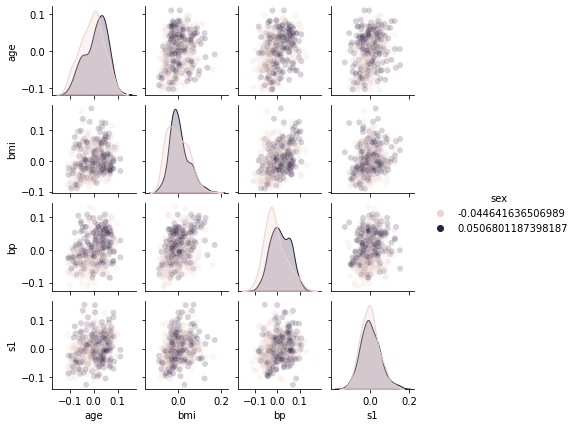

In [7]:
import seaborn as sns
sns.pairplot(diabetes_df[['age','sex','bmi','bp','s1']],
             size=1.5, hue='sex', plot_kws={'alpha': .2} );

# 4.2 Nearest-Neighbors Regression and Summary Statistics

When considering nearest-neighbor classification, we need to perform the following steps:

1. Describe similarity between pairs of examples.
2. Pick several of the most-similar examples.
3. Combine the picked examples into a single answer.

When considering Nearest-Neighbors regression, we must take into account the quantities represented by the outputs.  This means the first two steps stay the same, but step 3 requires adjustments.  Let's turn our attention to the median and the mean.


## 4.2.1 Measures of Center: Median and Mean

The median balances the *count* of values to the left and right, whereas the mean balances the total distances to the left and right.  So, the mean is the value for which `sum(distnace(s,mean) for s in smaller)` is equal to `sum(distance(b,mean) for b in bigger`.  Let's see what happens if we shift one value by 'a lot' and recompute the mean and median

In [8]:
values = np.array([1, 3, 5, 8, 11, 13, 15])
print('no outlier')
print(np.mean(values),
      np.median(values))

values_with_outlier = np.array([1, 3, 5, 8, 11, 13, 40])
print('with outlier')
print('%5.2f' % np.mean(values_with_outlier),
      np.median(values_with_outlier))

no outlier
8.0 8.0
with outlier
11.57 8.0


Beyond the mean and median, we can combine the nearest-neighbor answers into an answer for a text example using many possible ways.  One combiner that builds on the idea of the mean is the *weighted* mean.  In the nearest-neighbor context, we have a perfect candiate to serve as the weighting factor, the distance from our new example to the neighbor.  

Therefore, instead of neighbors contributing just their values \[4,0, 6.0, 8.0\], , we can also incorporate distance from each neighbor to our example.  Let's say those distances are \[2.0, 4.0, 4.0\], i.e., the second and third training examples are twice as far from our test example as the first one.  A simple way to incorporate the distance is to compute a *weighted average* using the following  

In [9]:
distances = np.array([2.0, 4.0, 4.0])
closeness = 1.0 / distances # element-by-element division
weights = closeness / np.sum(closeness) # normalize sum to one
weights

array([0.5 , 0.25, 0.25])

In mathese: $$ \frac{\frac{1}{distances}}{\Sigma(\frac{1}{distances})} $$

We use $\frac{1}{distances}$ since if you are *closer*, we want a *higher* weight; if you are *further*, but still a nearest neighbor, we want a *lower* weight.  We put the entire sum into the numerator to normalize the values so they sum to one.  Compare the mean with the weighted mean for these values:

In [10]:
values = np.array([4, 6, 8])

mean = np.mean(values)
wgt_mean = np.dot(values, weights)

print('Mean:', mean)
print('Weighted Mean:', wgt_mean)

Mean: 6.0
Weighted Mean: 5.5


## 4.2.2 Building a *k*-NN Regression Model

Now that we have some mental concepts to back up our undersatnding of *k*-NN regression, we can return to our basic `sklearn` workflow: build, fit, predict, evaluate.

In [11]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
fit = knn.fit(diabetes_train_ftrs, diabetes_train_tgt)
preds = fit.predict(diabetes_test_ftrs)

# evaluate our predictions against the held-back testing targets
metrics.mean_squared_error(diabetes_test_tgt, preds)

3471.41941941942

If you compare *k*-NN regression to the *k*-NN classifier, you'll only notice two differences.

1. We built a different model: this time we used `KNeighborsRegressor` instead of `KNeighborsClassifier`.
2. We used a different evaluation metric: this time we used `mean_squared_error` instead of `accuracy_score`.

Both reflect the difference in the targets we are trying to predict: numerical values, not Boolean categories.  To put the numerical value for MSE into context, let's look at two things.  First, the MSE is approximately 3500.  Let's take its square root--since we're adding up squares, we need to scale back to nonsquares:

In [12]:
np.sqrt(3500)

59.16079783099616

Now, let's look at the range of values that the target can take:

In [13]:
diabetes_df['target'].max() - diabetes_df['target'].min()

321.0

Therefore, the target values span about 300 units and our predictions are off--in some average sense--by 60 units.  That's around 20%.  Whether or not that is 'good enough' depends on many other factors which we'll see in Chapter 7.

# 7.3 Linear Regression and Errors

We are going to begin exploring linear regression by drawing high-jump bars.

In [14]:
def axis_helper(ax, lims):
    'clean up axes'
    ax.set_xlim(lims); ax.set_xticks([])
    ax.set_ylim(lims); ax.set_yticks([])
    ax.set_aspect('equal')

We're going to use some trivial data to show what's happening.

In [15]:
# our data is very simple: two (x, y) points
D = np.array([[3, 5],
              [4, 2]])

# we'll take x as our 'input' and y as our 'output'
x, y = D[:, 0], D[:, 1]

Now, let's graph what happens as we move a horizontal line up through different possible values.  This will represent our *predicted* values.  Also, we will calculate the sum of errors, the *sum of squares* of errors (abbreviated SSE), and the *square root of the sum of squared errors*.  

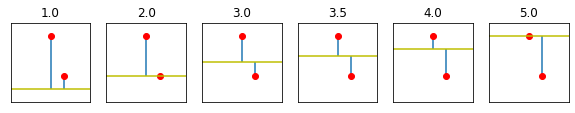

In [16]:
horizontal_lines = np.array([1, 2, 3, 3.5, 4, 5])
results = []
fig, axes = plt.subplots(1, 6, figsize=(10, 5))
for h_line, ax in zip(horizontal_lines, axes.flat):
    # styling
    axis_helper(ax, (0, 6))
    ax.set_title(str(h_line))
    
    # plot the data
    ax.plot(x, y, 'ro')
    
    # plot the prediction line
    ax.axhline(h_line, color='y') # ax coords; default to 100%
    
    # plot the errors
    # the horizontal line *is* our prediction; renaming for clarity
    predictions = h_line
    ax.vlines(x, predictions, y)
    
    # calculate the error amounts and their sum of squares
    errors = y - predictions
    sse = np.dot(errors, errors)
    
    # put together some results in a tuple
    results.append((predictions,
                    errors, errors.sum(),
                    sse, np.sqrt(sse)))

Let's take a look at the results.

In [17]:
col_labels = "Prediction", "Errors", "Sum", "SSE", "Distance"
display(pd.DataFrame.from_records(results, columns=col_labels, index="Prediction"))

,Errors,Sum,SSE,Distance
Prediction,,,,
1.0000,"[4.0, 1.0]",5.0000,17.0000,4.1231
2.0000,"[3.0, 0.0]",3.0000,9.0000,3.0000
3.0000,"[2.0, -1.0]",1.0000,5.0000,2.2361
3.5000,"[1.5, -1.5]",0.0000,4.5000,2.1213
4.0000,"[1.0, -2.0]",-1.0000,5.0000,2.2361
5.0000,"[0.0, -3.0]",-3.0000,9.0000,3.0000


The table includes the raw errors that can be positive or negative.  The sums of the raw errors do not do a great job of evaluating the lines because errors in the opposite directions, such as [2, -1], give us a total of 1 and cancel each other out.  One of the best ways to address this is to use a *total distance*.  That means we want something like $\sqrt{(prediction - actual)^2}$.  The SSE is the *sum of squared errors*, which gets us most of the way  towards calculating distances.  The last thing that's left to do is to take a square root.  The line that is best, under the rules so far, is the horizontal line at the mean of the points based on their vertical componoent: $\frac{5+2}{2} = 3.5$.  The mean is the best answer for the same reason it is the pivot on the balance beams shown earlier.  It perfectly balances off the error on each side.

## 4.3.2 Tilting the Field

The form of sloped lines is $y = mx + b$.  What does the distance from a point to our line look like?  It's just `distance(prediciton, y) = distance(m*x + b,y)`.  What is the total distance? Just add those up for all of our data: `sum(distance(mx + b, y) for x, y in D)`.  

What's our total distance? Just add those up for all of our data: `sum(distance(mx + b, y) for x, y in D)`.  In mathese, that looks like $ \Sigma_{x,y\in D} ((mx + b) - y)^2$

In [18]:
def process(D, model, ax):
    # make some useful abbreviations/names
    # y is our 'actual'
    x, y = D[:, 0], D[:, 1]
    m, b = model
    
    # styling
    axis_helper(ax, (0, 8))
    
    # plot the data
    ax.plot(x, y, 'ro')
    
    # plot the prediction line
    helper_xs = np.array([0, 8])
    helper_line = m * helper_xs + b
    ax.plot(helper_xs, helper_line, color='y')
    
    # plot the errors
    predictions = m * x + b
    ax.vlines(x, predictions, y)
    
    # calculate error amounts
    errors = y - predictions
    
    # tuple up the results
    sse = np.dot(errors, errors)
    return (errors, errors.sum(), sse, np.sqrt(sse))

Now we'll make use of `process` with several different prediction lines:

,Raw Errors,Sum,SSE,TotDist
0,"[2, -2]",0,8,2.8284
1,"[1, -3]",-2,10,3.1623
2,"[0, -4]",-4,16,4.0000
3,"[0, -2]",-2,4,2.0000
4,"[0, 0]",0,0,0.0000


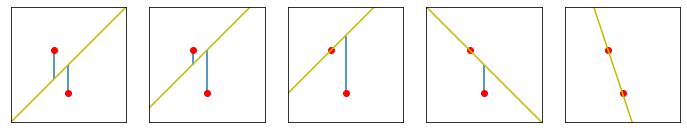

In [19]:
# our data is very simple: two (x, y) points
D = np.array([[3, 5],
              [4, 2]])

#                      m  b --> predictions = mx + b
lines_mb = np.array([[ 1, 0],
                     [ 1, 1],
                     [ 1, 2],
                     [-1, 8],
                     [-3, 14]])

col_labels = ('Raw Errors', 'Sum', 'SSE', 'TotDist')
results = []

# note: plotting occurs in process()
fig, axes = plt.subplots(1, 5, figsize=(12, 6))
records = [process(D, mod, ax) for mod,ax in zip(lines_mb, axes.flat)]
df = pd.DataFrame.from_records(records, columns=col_labels)
display(df)
                   

So we have a progression in calculating our measure of success:

* `predicted = m*x + b`
* `error = (m*x + b) - actual = predicted - actual`
* `SSE = sum(errors**2) = sum(((m*x+b) - actual)**2 for x,actual in data)`
* `total_distance = sqrt(SSE)`

The last line precisely intersects with both data points.

# 4.3.3 Performing Linear Regression

So far, we considered what happens when we have a single predictive feature, `x`.  When we track many different slopes, we use the term *weights* to describe the contribution of each feature.  Now, we can create a linear combination of the weights and the features to get the prediction for an example.  The prediction is coded in Python as `rdot(weights_wo, features) + wgt_b` if `weights_wo` is *without* the `b` part.  If we use the plus-one trick, it is `rdot(weights, features_p1)`, where `weights` includes a `b` (as `weights[0]`) and `features_p1` includes a column of ones.  Our error still looks like `distance(prediction, actual)` with `prediction=rdot(weights, features_p1)`.  The mathese form of a prediction looks like:

$$ y_{pred} = \Sigma_{ftrs} w_fx_f = w \dot x $$

In [20]:
lr = linear_model.LinearRegression()
fit = lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
preds = fit.predict(diabetes_test_ftrs)

# evaluate our predictions against the unseen testing targets
metrics.mean_squared_error(diabetes_test_tgt, preds)

2848.2953079329427

The `mean_squared_error` is the average distance of the errors in our prediction.

# Optimization: Picking the Best Answer

Here are four strategies we can adopt for picking the best answer:

1. Random guess: try lots of possibilities at random, take the best one.
2. Random step: Try one line--pick an *m* and a *b*--at random, make several random adjustments, pick the adjustment that helps the most. Repeat.
3. Smart step: try one line at random, see how it does, adjust it in some smart way. Repeat.
4. Calculated shortcut: Use fancy mathematics to prove that if Fact A, Fact B, and Fact C are all true, then the One Line to Rule Them All must be the best.

Let's run through these using a really, really simple constant-only model.

## 4.4.1 Random Guess

Let's make some simple data to predict.

In [21]:
tgt = np.array([3, 5, 8, 10, 12, 15])

Let's turn Method 1--random guessing--into some code.

In [22]:
# random guesses with some constraints
num_guesses = 10
results = []

for g in range(num_guesses):
    guess = np.random.uniform(low=tgt.min(), high=tgt.max())
    total_dist = np.sum((tgt - guess)**2)
    results.append((total_dist, guess))
best_guess = sorted(results)[0][1]
best_guess


8.228074784134693

Since we have a simple value to estimate, we only need to take a few shots to get a good answer.

## 4.4.2 Random Step

Method 2 starts with a single random guess, but then takes a random step up or down.  If the step is an improvement, we keep it.  Otherwise, we go back to where we were.

In [23]:
# use a random choice to take a hypothetical
# step up or down: follow it, if it is an improvement
num_steps = 100
step_size = .05

best_guess = np.random.uniform(low=tgt.min(), high=tgt.max())
best_dist = np.sum((tgt - best_guess)**2)

for s in range(num_steps):
    new_guess = best_guess + (np.random.choice([+1, -1]) * step_size)
    new_dist = np.sum((tgt - new_guess)**2)
    if new_dist < best_dist:
        best_guess, best_dist = new_guess, new_dist
print(best_guess)

8.836959712695537


## 4.4.3 Smart Step

Imagine walking, blindfolded, through a rock-stren field.  You might take tentative, test steps as you try to move around.  After a step, you use your foot to probe the area around you for a clear spot.

In [24]:
# hypotehtically take both steps (up and down)
# choose the better of the two
# if it is an improvement, follow that step
num_steps = 1000
step_size = .02

best_guess = np.random.uniform(low=tgt.min(), high=tgt.max())
best_dist = np.sum((tgt - best_guess)**2)
print('start:', best_guess)
for s in range(num_steps):
    # np.newaxis is needed to align the minus
    guesses = best_guess + (np.array([-1, 1]) * step_size)
    dists   = np.sum((tgt[:,np.newaxis] - guesses)**2, axis=0)
    
    better_idx = np.argmin(dists)
    
    if dists[better_idx] > best_dist:
        break
        
    best_guess = guesses[better_idx]
    best_dist  = dists[better_idx]
    
print("  end:", best_guess)

start: 9.575662598977047
  end: 8.835662598977063


Now, unless we get stuck in a bad stop, we should have a better shot at success than random stepping: at any given point we check out the legal alternatives and take the best of them.

# 4.4.4 Calculated Shortcuts

If you go to a statistics textbook, you'll discover that for our SSE evaluation criteria, there is a *formula* for the answer.  To get the smallest sum of squared errors, what we need is precisely the *mean*.  When we said earlier that the mean balanced the distances to the values, we were merely saying the same thing in a different way.  So, we don't actually have to search to find our best value.  The fancy footwork is in the mathematics that demonstrates that the mean is the right answer to the question.

In [25]:
print('mean:', np.mean(tgt))

mean: 8.833333333333334


# 4.4.5 Application to Linear Regression

We can apply these same ideas to fitting a sloped line, or finding many weights (one per feature), to our data points.  The model becomes a bit more complicated--we have to twiddle more values, either simultaneously or in sequence.  Still, it turns out that an equivalent to Method 4, the *Calculated Shortcut* is the standard, classical way to find the best line, which is called *least-squares fitting* and it is solved by the *normal equations.*  You don't have to remember that, instead just remember the *mean*.  

Our method 3, *Smart Step*, that uses some mathematics to limit the direction of our steps, is common when dealing with very big data where we can't run all the calculations needed for the standard method.  That method is called *gradient descent*.  Gradient descent (GD) uses some smart calculations--instead of probing steps--to determine directions of improvement. 

# 4.5 Simple Evaluation and Comparison of Regressors

Earlier, I promised we'd come back to the mean squared error (MSE).  Now that we've discussed sum of squared errors and total distances from a regression line, we can tie the ideas together nicely.

## 4.5.1 Root Mean Squared Error

How can we quantify the performance of regression predictions? We going to use some mathematics that are almost identical to our criteria for finding good lines.  Basically, we take the average of the squared errors. Remember, we can't just add up the errors themselves because then a +3 and a -3 would cancel each other out and we'd consider those predictions perfect when we're really off by a total of 6.  Squaring and adding the two values gives us a total error of 18.  

Averaging gives us a mean squared error of 9.  We take one other step and take the *square root* of the value to get back to the same scale as the errors themselves, giving us the *root mean squared error*, often abbreviated *RMSE*.  Notice that in this example, our RMSE is 3: precisely the amount of the error(s) in our individual predictions.  This reminds me of an old joke for which I can't find specific attribution:

## 4.5.2 Learning Performance

With data, methods, and an evaluation metric in hand, we can do a small comparison between *k*-NN-R and LR.

In [26]:
import numpy as np
# stand-alone code
from sklearn import (datasets, neighbors,
                     model_selection as skms,
                     linear_model, metrics)

diabetes = datasets.load_diabetes()
tts = skms.train_test_split(diabetes.data,
                            diabetes.target,
                            test_size=.25)

(diabetes_train, diabetes_test,
 diabetes_train_tgt, diabetes_test_tgt) = tts

models = {'kNN': neighbors.KNeighborsRegressor(n_neighbors=3),
          'linreg' : linear_model.LinearRegression()}

for name, model in models.items():
    fit = model.fit(diabetes_train, diabetes_train_tgt)
    preds = fit.predict(diabetes_test)

    score = np.sqrt(metrics.mean_squared_error(diabetes_test_tgt, preds))
    print("{:>6s} : {:0.2f}".format(name,score))

   kNN : 54.85
linreg : 46.95


## 4.5.3 Resource Utilization in Regression

If you compare the code here with the earlier code, you'll find two differences: (1) different learning methods and (2) a different learning performance metric.  Here is that script adapted for *k*-NN-R and LR:

```python
import timeit, sys
import functools as ft
import memory_profiler
from mlwpy import *

def knn_go(train_ftrs, test_ftrs, train_tgt):
    knn = neighbors.KNeighborsRegressor(n_neighbors=3)
    fit   = knn.fit(train_ftrs, train_tgt)
    preds = fit.predict(test_ftrs)

def lr_go(train_ftrs, test_ftrs, train_tgt):
    linreg = linear_model.LinearRegression()
    fit   = linreg.fit(train_ftrs, train_tgt)
    preds = fit.predict(test_ftrs)

def split_data(dataset):
    split = skms.train_test_split(dataset.data,
                                  dataset.target,
                                  test_size=.25)

    return split[:-1] # don't need test tgt

def msr_time(go, args):
    call = ft.partial(go, *args)
    tu = min(timeit.Timer(call).repeat(repeat=3, number=100))
    print("{:<6}: ~{:.4f} sec".format(go.__name__, tu))

def msr_mem(go, args):
    base = memory_profiler.memory_usage()[0]
    mu = memory_profiler.memory_usage((go, args),
                                       max_usage=True)
    print("{:<3}: ~{:.4f} MiB".format(go.__name__, mu-base))

if __name__ == "__main__":
    which_msr = sys.argv[1]
    which_go = sys.argv[2]

    msr = {'time': msr_time, 'mem':msr_mem}[which_msr]
    go = {'lr': lr_go, 'knn': knn_go}[which_go]

    sd = split_data(datasets.load_iris())
    msr(go, sd)
```

When we execute the script, we see:

In [27]:
!python perf_02.py mem lr
!python perf_02.py time lr

lr_go: ~0.4609 MiB
lr_go : ~0.0280 sec


In [28]:
!python perf_02.py mem knn
!python perf_02.py time knn 

knn_go: ~0.3047 MiB
knn_go: ~0.0669 sec


Here's a brief table of our results that might vary a bit over different runs:

Method | RMSE | Time (s) | Memory (MiB)
:-- | :-- | :-- | :--
*k*-NN-R | 55 | 0.06 | 0.2852
LR | 45 | 0.04 | 0.4297

It may be surprising that linear regression takes up so much memory, especially considering that *k*-NN-R requires keeping all the data around. This surprise highlights an issue with the way we measure memory: (1) we are measuring the *entire* fit-and-predict process as one unified task and (2) we are measuring the *peak* usage of the unified task.  

Even if linear regression has one brief moment of high usage, that's what we are going to see.  Under the hood, this form of linear regression, which optimizes by Method 4, *Calculated Shortcut*, isn't super clever about how it does its calculations.  There's a critical part of its operation--solving those normal equations I mentioned above--that is very memory hungry.

